In [1]:
from evaluation_utils import read_global_results, unpivot_baseline_model, unpivot_ssl_model, read_multiple_global_results
from constants import MODE_1_PROCESSED_DIR, MODE_2_3_PROCESSED_DIR, TEST_METRIC, ENCODERS, TRAINING_SCHEMES, SSL_MODELS, BASELINES, ENCODER_COLORS, SINGLE_ENCODER_MODELS, \
                        GENERATION_ALL, AUXILIARY_ALL, CONTRAST_ALL, HYBRID_ALL
                    
import pandas as pd
import itertools
from collections import defaultdict, OrderedDict
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FixedFormatter, FixedLocator
import seaborn as sns
import matplotlib.gridspec as gridspec
import matplotlib as mpl
import numpy as np
import missingno as msno

In [2]:
data = read_global_results(MODE_2_3_PROCESSED_DIR)

1.ndjson
2.ndjson
3.ndjson
4.ndjson
5.ndjson
6.ndjson
7.ndjson
8.ndjson
9.ndjson
10.ndjson
11.ndjson
12.ndjson
13.ndjson
14.ndjson
15.ndjson
16.ndjson
concatenating


In [3]:
# SSL results
df_ssl = unpivot_ssl_model(df=data, suffix=TEST_METRIC, ssl_models=SSL_MODELS, encoders=ENCODERS, training_schemes=TRAINING_SCHEMES)
df_baseline = unpivot_baseline_model(df=data, suffix=TEST_METRIC, baseline_models=BASELINES, training_schemes=TRAINING_SCHEMES)

In [4]:
# group by the specified columns and calculate the mean of test_rocauc_ovr
grouped_df = df_ssl.groupby(['SSL_model', 'Encoder', 'Training_scheme'])['test_rocauc_ovr'].mean().reset_index()
new_df = grouped_df[['SSL_model', 'Encoder', 'Training_scheme', 'test_rocauc_ovr']]

# define a function to rank the SSL_model within each group
def rank_models(group):
    group['SSL_rank'] = group['test_rocauc_ovr'].rank(ascending=False, method="min")
    return group

ranked_df = new_df.groupby(['Encoder', 'Training_scheme']).apply(rank_models)
# select the desired columns and sort the dataframe
final_df = ranked_df[['Training_scheme', 'Encoder', 'SSL_model', 'SSL_rank', 'test_rocauc_ovr']].sort_values(['Training_scheme', 'Encoder',  'SSL_rank'])

In [41]:
df_baseline.groupby("Baseline_model").mean()

,test_rocauc_ovr,Graph_ID
Baseline_model,,
GAT,0.903192,10742.5
GCN,0.904347,10742.5
GIN,0.858026,10742.5


/tmp/ipykernel_32758/2071772049.py:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.set_ticklabels([str(t) for t in np.linspace(1, len(SSL_MODELS), 6)])


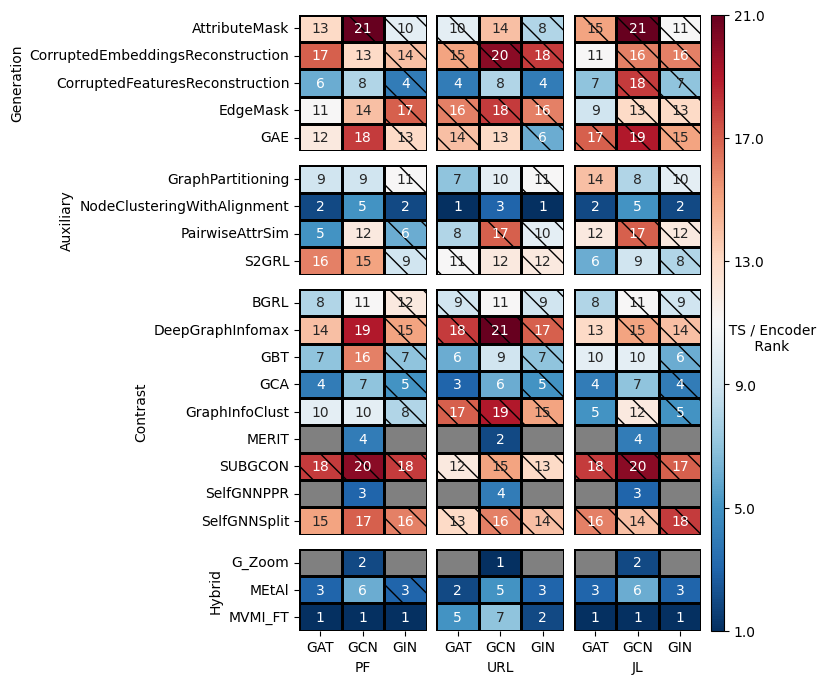

In [54]:
# Plotting ranks per TS/Encoder sceme

fig=plt.figure(figsize=(5,8))
all_categories = [GENERATION_ALL, AUXILIARY_ALL, CONTRAST_ALL, HYBRID_ALL]
height_ratios = [len(category) / len(SSL_MODELS) for category in all_categories]
gs = gridspec.GridSpec(4, 4, width_ratios=[1,1,1,0.1], height_ratios=height_ratios)
gs.update(left=0.1, right=0.95, wspace=0.1, hspace=0.1)

for i, (category, category_name) in enumerate(zip(all_categories, ["Generation", "Auxiliary", "Contrast", "Hybrid"])):
    category_df = final_df[final_df["SSL_model"].isin(category)]
    for j, ts in enumerate(TRAINING_SCHEMES):
        ax=plt.subplot(gs[i,j]) 
        ts_df = category_df[category_df["Training_scheme"] == ts]
        plotting_df = ts_df.pivot(index=['SSL_model'], columns=['Encoder'], values='SSL_rank')
        g = sns.heatmap(plotting_df, cmap='RdBu_r', cbar=False, annot=True, 
                    linewidths=1, vmin = 1, vmax=len(SSL_MODELS), linecolor="black")
        g.set_facecolor("grey")

        hatch_df = ts_df.pivot(index=['SSL_model'], columns=['Encoder'], values=TEST_METRIC)
        #mask = np.ma.masked_equal(hatch_df.applymap(lambda x: x.mid if pd.notnull(x) else 0).values, bin.mid)
        ax.pcolor(np.arange(len(plotting_df.columns)+1), np.arange(len(plotting_df.index)+1), 
                  np.where((hatch_df.values < 0.904347), hatch_df.values, np.nan), hatch="\\", alpha=0.)


        if j != 0:
            ax.set_ylabel("")
            ax.set_yticks([])
        else:
            ax.set_ylabel(category_name)
        if i != 3:
            ax.set_xlabel("")
            ax.set_xticks([])
        else:
            ax.set_xlabel(ts)
        ax.set_yticklabels(ax.get_yticklabels(), rotation=0)



ax_bar=plt.subplot(gs[:,3]  )
cbar = mpl.colorbar.ColorbarBase(ax_bar, cmap="RdBu_r")
cbar.set_ticklabels([str(t) for t in np.linspace(1, len(SSL_MODELS), 6)])
cbar.set_label("  TS / Encoder \n Rank", rotation=0)


In [77]:
ranked_df2

0       93.0
1       64.0
2      112.0
3      115.0
4      102.0
       ...  
166     88.0
167    110.0
168    165.0
169    155.0
170    167.0
Name: test_rocauc_ovr, Length: 171, dtype: float64

/tmp/ipykernel_32758/2075198284.py:44: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.set_ticklabels([str(t) for t in np.linspace(1, len(SSL_MODELS)*3*3 - 12, 6, dtype=int)])


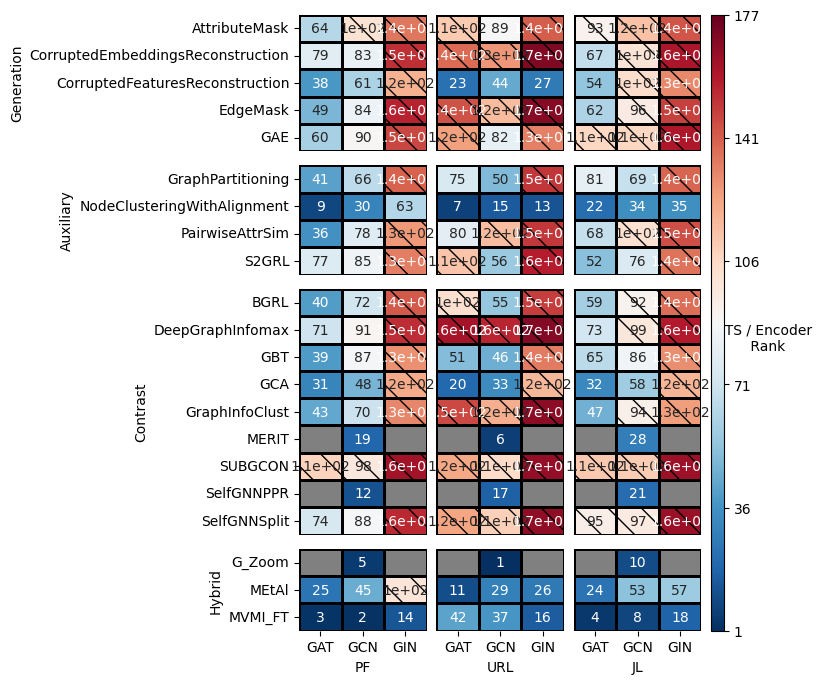

In [88]:
# Plotting global ranks (n~170)
ranked_df2 = new_df.copy()
ranked_df2['SSL_rank'] = ranked_df2['test_rocauc_ovr'].rank(ascending=False, method="min")

# Plotting ranks per TS/Encoder sceme

fig=plt.figure(figsize=(5,8))
all_categories = [GENERATION_ALL, AUXILIARY_ALL, CONTRAST_ALL, HYBRID_ALL]
height_ratios = [len(category) / len(SSL_MODELS) for category in all_categories]
gs = gridspec.GridSpec(4, 4, width_ratios=[1,1,1,0.1], height_ratios=height_ratios)
gs.update(left=0.1, right=0.95, wspace=0.1, hspace=0.1)

for i, (category, category_name) in enumerate(zip(all_categories, ["Generation", "Auxiliary", "Contrast", "Hybrid"])):
    category_df = ranked_df2[ranked_df2["SSL_model"].isin(category)]
    for j, ts in enumerate(TRAINING_SCHEMES):
        ax=plt.subplot(gs[i,j]) 
        ts_df = category_df[category_df["Training_scheme"] == ts]
        plotting_df = ts_df.pivot(index=['SSL_model'], columns=['Encoder'], values='SSL_rank')
        g = sns.heatmap(plotting_df, cmap='RdBu_r', cbar=False, annot=True,
                    linewidths=1, vmin = 1, vmax=len(SSL_MODELS)*3*3 - 12, linecolor="black")
        g.set_facecolor("grey")

        hatch_df = ts_df.pivot(index=['SSL_model'], columns=['Encoder'], values=TEST_METRIC)
        ax.pcolor(np.arange(len(plotting_df.columns)+1), np.arange(len(plotting_df.index)+1), 
                  np.where((hatch_df.values < 0.904347), hatch_df.values, np.nan), hatch="\\", alpha=0.)


        if j != 0:
            ax.set_ylabel("")
            ax.set_yticks([])
        else:
            ax.set_ylabel(category_name)
        if i != 3:
            ax.set_xlabel("")
            ax.set_xticks([])
        else:
            ax.set_xlabel(ts)
        ax.set_yticklabels(ax.get_yticklabels(), rotation=0)



ax_bar=plt.subplot(gs[:,3]  )
cbar = mpl.colorbar.ColorbarBase(ax_bar, cmap="RdBu_r")
cbar.set_ticklabels([str(t) for t in np.linspace(1, len(SSL_MODELS)*3*3 - 12, 6, dtype=int)])
cbar.set_label("  TS / Encoder \n Rank", rotation=0)

/tmp/ipykernel_32758/95214544.py:6: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  flights = flights.pivot("month", "year", "passengers")


year   1949  1950  1951  1952  1953  1954  1955  1956  1957  1958  1959  1960
month                                                                        
Jan     112   115   145   171   196   204   242   284   315   340   360   417
Feb     118   126   150   180   196   188   233   277   301   318   342   391
Mar     132   141   178   193   236   235   267   317   356   362   406   419
Apr     129   135   163   181   235   227   269   313   348   348   396   461
May     121   125   172   183   229   234   270   318   355   363   420   472
Jun     135   149   178   218   243   264   315   374   422   435   472   535
Jul     148   170   199   230   264   302   364   413   465   491   548   622
Aug     148   170   199   242   272   293   347   405   467   505   559   606
Sep     136   158   184   209   237   259   312   355   404   404   463   508
Oct     119   133   162   191   211   229   274   306   347   359   407   461
Nov     104   114   146   172   180   203   237   271   305   31

Traceback (most recent call last):
  File "_pydevd_bundle/pydevd_cython.pyx", line 1134, in _pydevd_bundle.pydevd_cython.PyDBFrame.trace_dispatch
  File "_pydevd_bundle/pydevd_cython.pyx", line 311, in _pydevd_bundle.pydevd_cython.PyDBFrame.do_wait_suspend
  File "/home/beke/.conda/envs/scara/lib/python3.10/site-packages/debugpy/_vendored/pydevd/pydevd.py", line 2062, in do_wait_suspend
    keep_suspended = self._do_wait_suspend(thread, frame, event, arg, suspend_type, from_this_thread, frames_tracker)
  File "/home/beke/.conda/envs/scara/lib/python3.10/site-packages/debugpy/_vendored/pydevd/pydevd.py", line 2098, in _do_wait_suspend
    time.sleep(0.01)
KeyboardInterrupt


KeyboardInterrupt: 

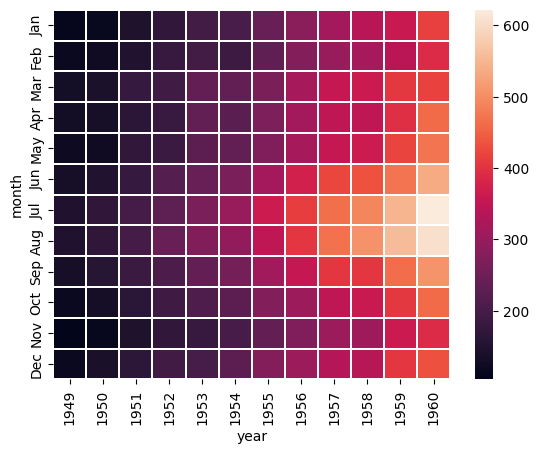

In [22]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

flights = sns.load_dataset("flights")
flights = flights.pivot("month", "year", "passengers")
print(flights)
zm = np.ma.masked_less(flights.values, 200)
x= np.arange(len(flights.columns)+1)
y= np.arange(len(flights.index)+1)
sns.heatmap(flights,linewidth=.1)
plt.pcolor(x, y, zm, hatch='//', alpha=0.)

plt.show()

In [67]:
rank_lines = defaultdict(list)
for i, (name, group) in enumerate(final_df.groupby(['Training_scheme', 'Encoder'])):
    for ssl_model in SSL_MODELS:
        if ssl_model in SINGLE_ENCODER_MODELS:
            continue
        rank = group[group['SSL_model'] == ssl_model]['SSL_rank'].reset_index(drop=True)
        rank_lines[ssl_model].append(rank.iloc[0])


In [63]:
rank_lines

defaultdict(list,
            {'AttributeMask': [0.9042530373190028,
              0.8921131084051847,
              0.8658245325026994,
              0.9117601005977132,
              0.899477465149915,
              0.869178346340707,
              0.8939713181589504,
              0.905316077832824,
              0.8661399118602339],
             'CorruptedEmbeddingsReconstruction': [0.9104021434389357,
              0.8996905663796329,
              0.8564069251175781,
              0.9075503736806652,
              0.9071009515695274,
              0.8605677307573799,
              0.8667147514150224,
              0.875157655702026,
              0.7871529734690956],
             'CorruptedFeaturesReconstruction': [0.913624679882044,
              0.898257370054635,
              0.8726080915503358,
              0.9211534325454223,
              0.912299004435091,
              0.8792276114191119,
              0.9352955469039025,
              0.9191209096125813,
              

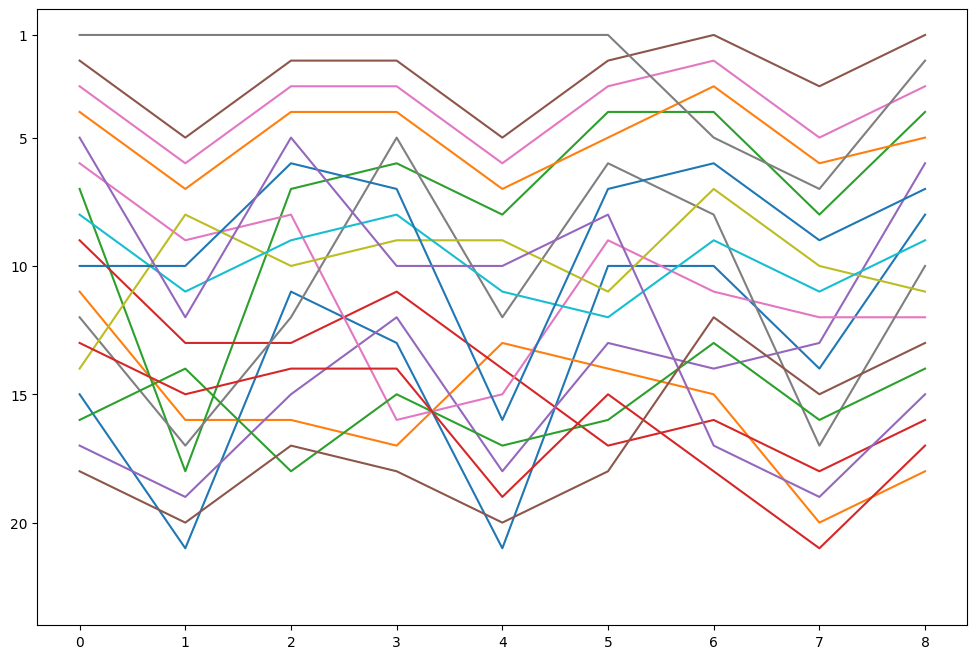

In [70]:
# create a figure and axis object
fig, ax = plt.subplots(figsize=(12, 8))

for method, ranks in rank_lines.items():
    plt.plot(range(len(ranks)), ranks, label=method)


# plt.ylim(0.88, 1.0)
plt.ylim(24,0)
plt.yticks([20, 15, 10, 5, 1])
# show the plot
plt.show()

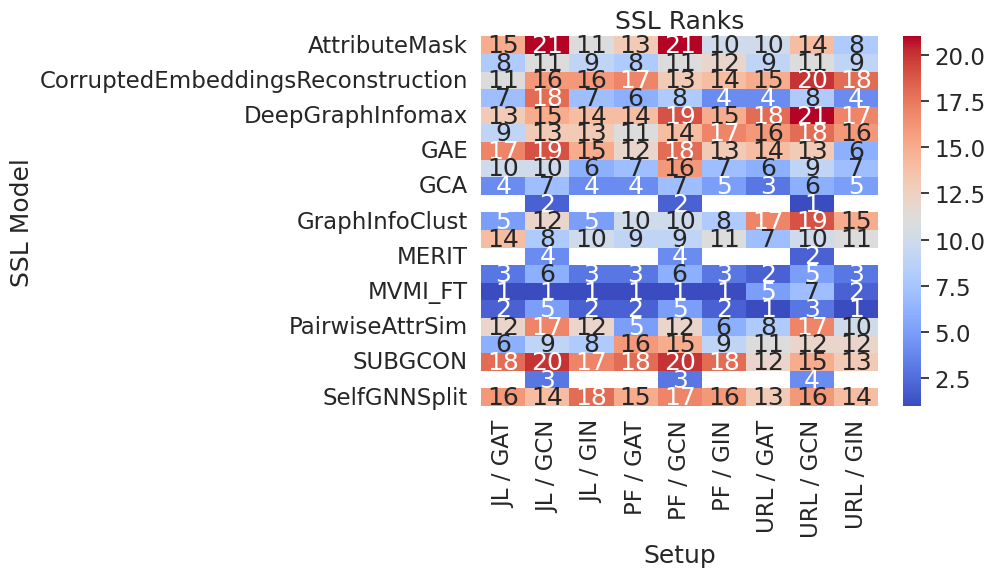

In [84]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a new column to store the combination of Training_scheme and Encoder
final_df['Setup'] = final_df['Training_scheme'] + ' / ' + final_df['Encoder']

# Pivot the data to create a matrix of SSL_ranks
pivot_df = final_df.pivot(index=['SSL_model'], columns=['Setup'], values='SSL_rank')

# Create the heatmap
sns.heatmap(pivot_df, annot=True, fmt='g', cmap='coolwarm')

# Add labels and title
plt.title('SSL Ranks')
plt.xlabel('Setup')
plt.ylabel('SSL Model')

# Show the plot
plt.show()


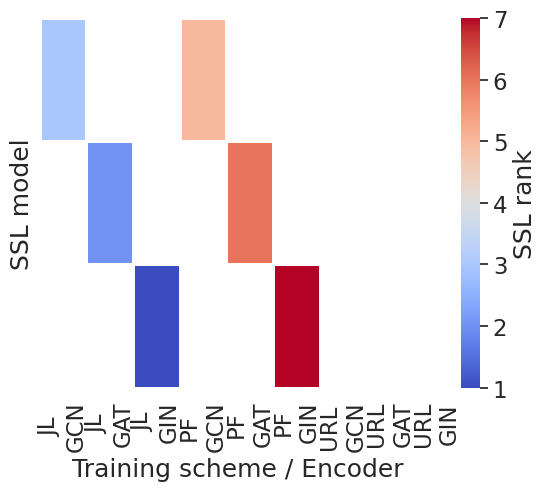

In [83]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a pivot table of the data
pivot_table = df.pivot_table(values='SSL_rank', index='SSL_model', columns=['Training_scheme', 'Encoder'], aggfunc='mean')

# Define the groups for the x-axis
x_groups = [('JL', 'GCN'), ('JL', 'GAT'), ('JL', 'GIN'),
            ('PF', 'GCN'), ('PF', 'GAT'), ('PF', 'GIN'),
            ('URL', 'GCN'), ('URL', 'GAT'), ('URL', 'GIN')]

# Create the custom heatmap
sns.set(font_scale=1.5)
sns.set_style("white")
sns.heatmap(pivot_table, cmap="coolwarm", cbar_kws={'label': 'SSL rank'},
            xticklabels=['\n'.join(g) for g in x_groups], yticklabels=[],
            linewidths=1, linecolor='white')

# Add the x-axis labels
plt.xlabel('Training scheme / Encoder', fontsize=18)
plt.ylabel('SSL model', fontsize=18)

# Show the plot
plt.show()


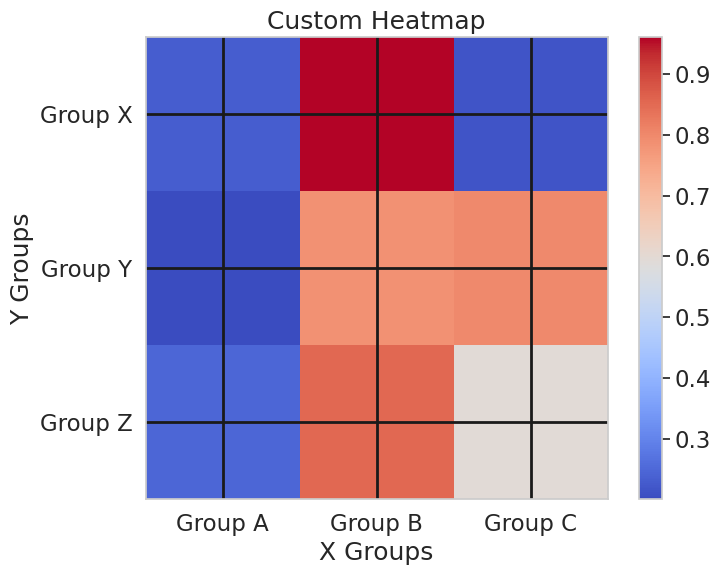

In [79]:
import matplotlib.pyplot as plt
import numpy as np

# Define the groups and their respective labels
x_groups = ['Group A', 'Group B', 'Group C']
y_groups = ['Group X', 'Group Y', 'Group Z']

# Generate some sample data for the heatmap
data = np.random.rand(len(y_groups), len(x_groups))

# Set the figure size and create a new figure
fig, ax = plt.subplots(figsize=(8, 6))

# Create the heatmap with the specified whitespace
heatmap = ax.imshow(data, cmap='coolwarm', interpolation='nearest')

# Set the tick labels for the x and y axes
ax.set_xticks(np.arange(len(x_groups)))
ax.set_xticklabels(x_groups)
ax.set_yticks(np.arange(len(y_groups)))
ax.set_yticklabels(y_groups)

# Add the colorbar to the heatmap
cbar = ax.figure.colorbar(heatmap, ax=ax)

# Set the title and labels for the heatmap
ax.set_title('Custom Heatmap')
ax.set_xlabel('X Groups')
ax.set_ylabel('Y Groups')

# Configure the whitespace between the groups
ax.set_xlim(-0.5, len(x_groups)-0.5)
ax.set_ylim(len(y_groups)-0.5, -0.5)

# Add the gridlines to the heatmap
ax.grid(which='major', axis='both', linestyle='-', color='k', linewidth=2)

# Show the final plot
plt.show()


In [80]:
data

array([[0.23271265, 0.96014878, 0.21764037],
       [0.20102259, 0.7841852 , 0.79876152],
       [0.24587112, 0.85166163, 0.59354969]])

In [57]:
df_baseline

,test_rocauc_ovr,Baseline_model,Graph_ID,Experiment
0,0.953306,GCN,0,Mode 1
1,0.945873,GCN,1,Mode 1
2,0.857083,GCN,2,Mode 1
3,0.853678,GCN,3,Mode 1
4,0.650312,GCN,4,Mode 1
...,...,...,...,...
358282,0.819011,GIN,119424,Mode 2/3
358283,0.898181,GIN,119425,Mode 2/3
358284,0.942738,GIN,119426,Mode 2/3
358285,0.684476,GIN,119427,Mode 2/3


/tmp/ipykernel_48654/1071568612.py:15: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for mode, group in df_baseline.groupby(['Experiment']):
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


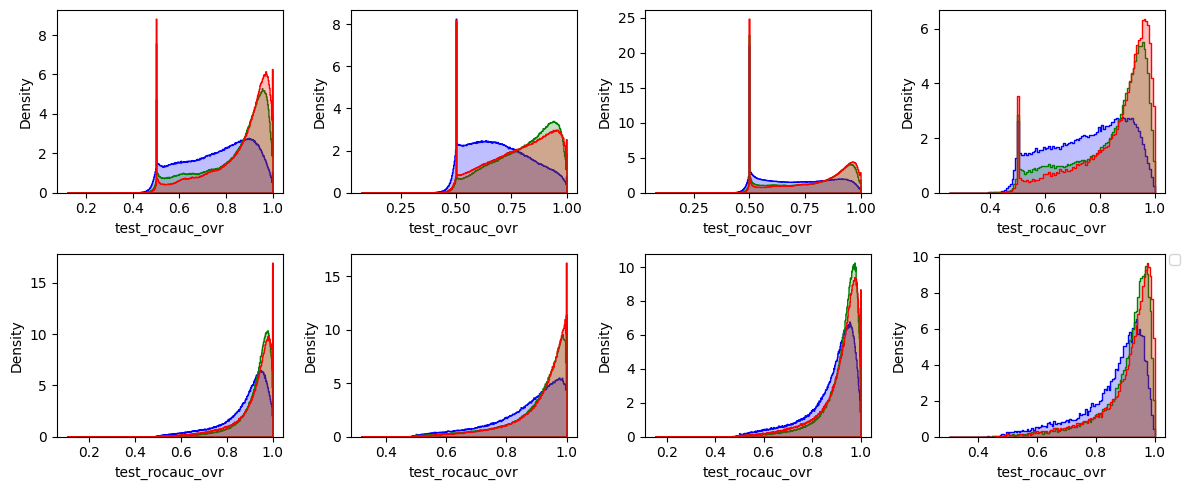

In [69]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(12, 5))

groups = defaultdict(lambda: defaultdict(lambda: defaultdict()))
for (mode, ts), group in df_ssl.groupby(['Experiment', 'Training_scheme']):
    groups[mode][ts] = group
for i, mode in enumerate(groups.keys()):
    for j, ts in enumerate(TRAINING_SCHEMES):
        sns.histplot(data=groups[mode][ts], x=TEST_METRIC, hue="Encoder", ax = axes[i][j], 
                     palette=ENCODER_COLORS, stat="density", element="step", common_norm=False, legend=False)

groups_base = defaultdict()
for mode, group in df_baseline.groupby(['Experiment']):
    groups_base[mode] = group
for i, mode in enumerate(groups_base.keys()):
    sns.histplot(data=groups_base[mode], x=TEST_METRIC, hue="Baseline_model", ax = axes[i][3], 
                 palette=ENCODER_COLORS, stat="density", element="step", common_norm=False, legend=False)

# Final plotting details 
fig.tight_layout()
plt.show()

